In [10]:
import jax.numpy as jnp
import jax
import jax.scipy as jsp
import matplotlib.pyplot as plt
import os

Lets load some images.

In [57]:
def load_data(path, count=100):
    # load all images from this path
    images = []
    i = 0
    for file in os.listdir(path):
        i += 1
        if i > count:
            break
        if file.endswith(".jpg"):
            images.append(plt.imread(os.path.join(path, file)))

    return images

def preprocess(images, size=32, batch_size=32, batch_count=10):
    # resize with jax vectorization
    images = [jax.image.resize(image, (size, size, 3), method="linear") for image in images]
    # reshape
    images = jnp.array(images)
    # normalize
    images = images / 255.0

    batches = images.reshape((batch_count, batch_size, size, size, 3))

    return batches

batch_size = 16
batch_count = 16
images_raw = load_data("data", count=batch_size * batch_count)
print(len(images_raw))
batches = preprocess(images_raw, size=32, batch_size=batch_size, batch_count=batch_count)
print(batches[0].shape)

256
(16, 32, 32, 3)


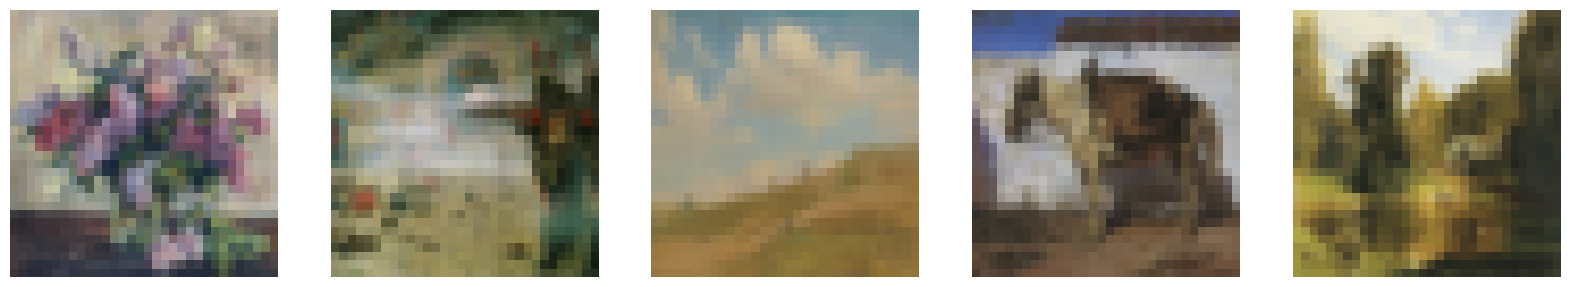

In [58]:

# generate 5 plots in a row
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    axs[i].imshow(batches[0][i])
    axs[i].axis("off")

In [59]:
from flax import linen as nn
from flax import struct
import optax
from typing import Any, Callable

In [60]:
class Encoder(nn.Module):
    n_channels: int

    def setup(self):
        self.conv1 = nn.Conv(features=self.n_channels, kernel_size=(3, 3), strides=(2, 2))
        self.conv2 = nn.Conv(features=4*self.n_channels, kernel_size=(3, 3), strides=(2, 2))
        self.conv3 = nn.Conv(features=16*self.n_channels, kernel_size=(3, 3), strides=(2, 2))

    def __call__(self, x):
        x = self.conv1(x)
        x = jax.nn.relu(x)
        x = self.conv2(x)
        x = jax.nn.relu(x)
        x = self.conv3(x)
        x = jax.nn.relu(x)
        return x

In [61]:
class Decoder(nn.Module):
    n_channels: int

    def setup(self):
        self.conv1 = nn.ConvTranspose(features=16*self.n_channels, kernel_size=(3, 3), strides=(2, 2))
        self.conv2 = nn.ConvTranspose(features=4*self.n_channels, kernel_size=(3, 3), strides=(2, 2))
        self.conv3 = nn.ConvTranspose(features=self.n_channels, kernel_size=(3, 3), strides=(2, 2))
    
    def __call__(self, x):
        x = self.conv1(x)
        x = jax.nn.relu(x)
        x = self.conv2(x)
        x = jax.nn.relu(x)
        x = self.conv3(x)
        x = jax.nn.relu(x)

        return x

In [62]:
class Autoencoder(nn.Module):
    n_channels: int

    def setup(self):
        self.encoder = Encoder(n_channels=self.n_channels)
        self.decoder = Decoder(n_channels=self.n_channels)
    
    def __call__(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [70]:
from functools import partial

def reconstruction_loss(network_params : optax.Params,  network : nn.Module, images : jnp.ndarray):
  # print(images.shape)
  prediction = network.apply(network_params, images)
  # print(prediction.shape)
  # print(prediction.shape, images.shape)
  loss = jnp.mean(jnp.sum(jnp.square(prediction - images), axis=(-1)))
  return loss

@partial(jax.jit, static_argnums=(1,2))
def train_step(
  batch : jnp.ndarray,
  network : nn.Module,
  optimizer : optax.GradientTransformation,
  optimizer_state : optax.OptState,
  network_params : optax.Params):

  grad_fn = jax.value_and_grad(reconstruction_loss, argnums=0)
  loss, grads = grad_fn(network_params, network, batch)

  updates, new_opt_state = optimizer.update(grads, optimizer_state)

  new_network_params = optax.apply_updates(network_params, updates)

  return loss, new_network_params, new_opt_state


In [73]:
init_rng = jax.random.key(0)

learning_rate = 0.003

autoencoder = Autoencoder(n_channels=3)

network_params = autoencoder.init(init_rng, batches[0][0])
print(batches[0].shape)
# autoencoder_params = autoencoder_state
optimizer = optax.adam(learning_rate)
optimizer_state = optimizer.init(network_params)

num_epochs = 60

for epoch in range(num_epochs):

    def body_func(i, state):
        loss_sum, network_params, optimizer_state = state
        loss, network_params, optimizer_state = train_step(batches[i], autoencoder, optimizer, optimizer_state, network_params)
        return loss_sum + loss, network_params, optimizer_state
    
    state = (0., network_params, optimizer_state)
    state = jax.lax.fori_loop(0, len(batches), body_func, state)

    loss, network_params, optimizer_state = state

    print(f"Epoch {epoch}, Loss: {loss}")


(16, 32, 32, 3)
Epoch 0, Loss: 7.161273002624512
Epoch 1, Loss: 2.0096874237060547
Epoch 2, Loss: 1.1851869821548462
Epoch 3, Loss: 0.9018904566764832
Epoch 4, Loss: 0.7394517660140991
Epoch 5, Loss: 0.6349304914474487
Epoch 6, Loss: 0.581722617149353
Epoch 7, Loss: 0.5481858849525452
Epoch 8, Loss: 0.52357417345047
Epoch 9, Loss: 0.5043771266937256
Epoch 10, Loss: 0.48841041326522827
Epoch 11, Loss: 0.47375431656837463
Epoch 12, Loss: 0.4610298275947571
Epoch 13, Loss: 0.4492684006690979
Epoch 14, Loss: 0.440834105014801
Epoch 15, Loss: 0.4286960959434509
Epoch 16, Loss: 0.4201745390892029
Epoch 17, Loss: 0.41451939940452576
Epoch 18, Loss: 0.40587908029556274
Epoch 19, Loss: 0.39565515518188477
Epoch 20, Loss: 0.38455507159233093
Epoch 21, Loss: 0.37118104100227356
Epoch 22, Loss: 0.363205224275589
Epoch 23, Loss: 0.36212849617004395
Epoch 24, Loss: 0.3548972010612488
Epoch 25, Loss: 0.3446654677391052
Epoch 26, Loss: 0.3334973156452179
Epoch 27, Loss: 0.3150448799133301
Epoch 28, Lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.041736964..1.0275401].


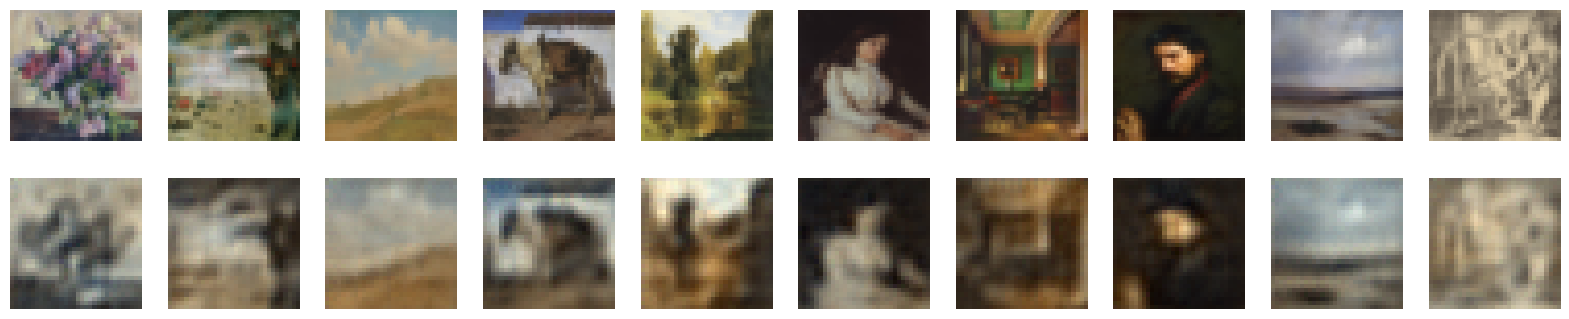

In [74]:
# plot a few reconstructions and the original images
fig, axs = plt.subplots(2, 10, figsize=(20, 4))

for i in range(10):
    axs[0, i].imshow(batches[0][i])
    axs[0, i].axis("off")
    axs[1, i].imshow(autoencoder.apply(network_params, batches[0][i][None])[0])
    axs[1, i].axis("off")

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5105681].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.4344172].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.5072381].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.197996].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.106516].


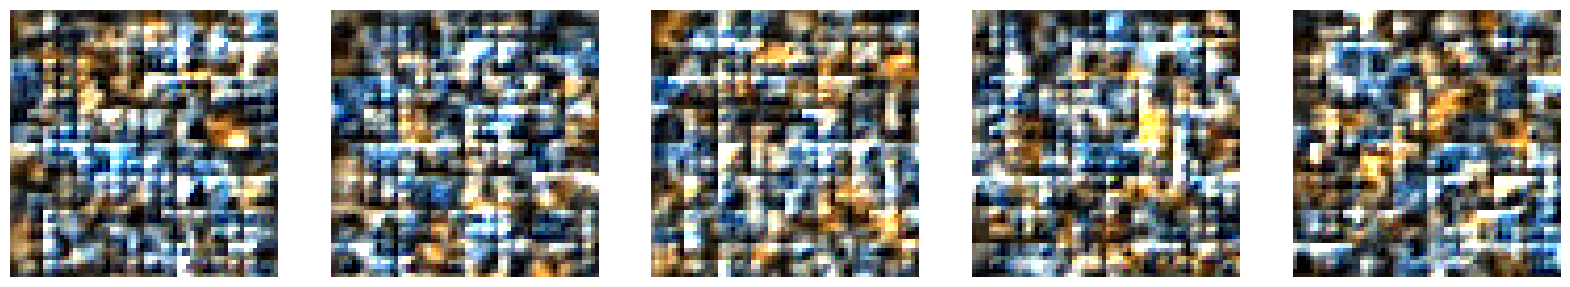

In [79]:
# generate new images from the latent space

encoder = Decoder(n_channels=3)
params = {'params':network_params['params']['decoder']}

keys = jax.random.split(init_rng, 5)
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    latent = jax.random.normal(keys[i], (1, 8, 8, 3*16))
    image = encoder.apply(params, latent)
    axs[i].imshow(image[0])
    axs[i].axis("off")
